In [2]:
import pandas as pd
import json
import re


# 훈련 방식 목차
---
1. 데이터 불러오기
2. 데이터 전처리
    - 1) first_party, second_party ner
        - 만약 ner 결과가 2 이상은 직접 데이터 확인해서 manual 하게 처리
        - 결과가 1인 경우에는 다 
    - 2) concat the ner result to df 
    - 3) barchart on the ner tags
    - 4) filter human name
    - 5) check is first_party(full name, first name, last name) in the facts
    - 6) concat the result to df 
    - 7) make prompt
3. Generative QA 적용
    - LLAMA 모델 파인튜닝
    - 다른 모델 파인 튜닝
    
4. 결과 확인
    

In [3]:
df = pd.read_csv('train.csv')
print(len(df))

2478


In [3]:
df.head()

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


## NER on first_party, second_party

1) first_party와 second_party에 대해서 ner 수행
2) 일단 ner 결과가 하나만 나온 녀석들에 대해서만 파생변수 생성
3) 2개 이상의 결과가 나온 경우에는 로직 생각해봅시다

    - full name이 있는 DF의 경우에는 태그를 통해 다시 탐색 안해도 됨 => full name df로 뺌
    
    - full name이 없는 DF 애들 속에서 탐색 해야함
        
        - full name이 없는 애들 중에서 다시 ner 결과가 둘 다 1인 애들만 뺌
        - 2개 이상의 결과가 나온 애들은 DF 다시 나누기

<AxesSubplot:>

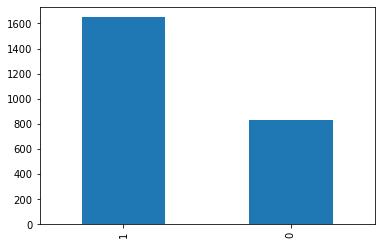

In [7]:
a = df['first_party_winner'].value_counts()
a.plot.bar()

In [4]:
from transformers import pipeline
from collections import Counter

In [5]:
token_classifier = pipeline(model="Jean-Baptiste/camembert-ner", aggregation_strategy="simple")

ner_result = []

for i in range(len(df)):
    first_party, second_party = df['first_party'][i], df['second_party'][i]
    
    
    tokens_first = token_classifier(first_party)
    tokens_second = token_classifier(second_party)
    ner_result.append([i, tokens_first, tokens_second])

In [6]:
## ner 결과가 하나인 친구에 대해서만 수행

normal_ner_first = list(filter(lambda x: len(x[1]) ==1, ner_result))
normal_ner_first_idx = list(map(lambda x: x[0], normal_ner_first))
normal_ner_first_tag = list(map(lambda x: x[1][0]['entity_group'], normal_ner_first))


normal_ner_second = list(filter(lambda x: len(x[2]) ==1, ner_result))
normal_ner_second_idx = list(map(lambda x: x[0], normal_ner_second))
normal_ner_second_tag = list(map(lambda x: x[2][0]['entity_group'], normal_ner_second))

df['tag_first'] = ['OOV'] * len(df)
df['tag_second'] = ['OOV'] * len(df)
df.loc[normal_ner_first_idx, 'tag_first'] = normal_ner_first_tag
df.loc[normal_ner_second_idx, 'tag_second'] = normal_ner_second_tag


In [7]:
df.head()

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,PER,PER
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,PER,PER
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,PER,OOV
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,MISC,PER
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,PER,LOC


<AxesSubplot:>

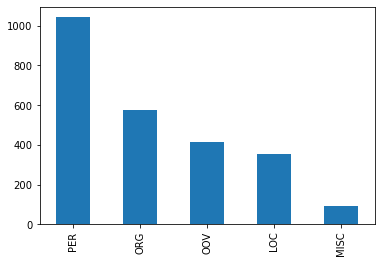

In [8]:
df['tag_first'].value_counts().plot.bar()

<AxesSubplot:>

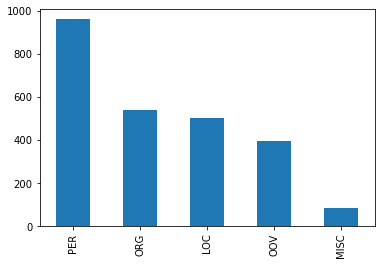

In [9]:
df['tag_second'].value_counts().plot.bar()

In [10]:

##full name
isin_first = tuple(zip(df['first_party'], df['facts']))
isin_second = tuple(zip(df['second_party'], df['facts']))

isin_first = tuple(map(lambda x: 1 if x[0] in x[1] else 0, isin_first))
isin_second = tuple(map(lambda x: 1 if x[0] in x[1] else 0, isin_second))
df['isin_first_full'] = isin_first
df['isin_second_full'] = isin_second


full_name_df = df[(df['isin_first_full'] == 1)|(df['isin_second_full'] == 1)].reset_index(drop=True)


no_full_df = df[(df['isin_first_full'] == 0) &(df['isin_second_full'] == 0)].reset_index(drop=True)

In [11]:
# len(df[(df['isin_first_full'] == 0) &(df['isin_second_full'] == 1)]) # 0개
# len(df[(df['isin_first_full'] == 1) &(df['isin_second_full'] == 0)]) # 0개

In [12]:
full_name_df

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full
0,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,PER,PER,0,1
1,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,PER,OOV,1,0
2,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,MISC,PER,1,0
3,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,PER,LOC,1,1
4,TRAIN_0007,"US Airways, Inc.",Barnett,"In 1990, Robert Barnett injured his back while...",1,ORG,PER,0,1
...,...,...,...,...,...,...,...,...,...
1545,TRAIN_2472,United States,Cuauhtemoc Gonzalez-Lopez,"Cuauhtemoc Gonzalez-Lopez hired Joseph Low, an...",0,LOC,PER,0,1
1546,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",1,OOV,ORG,1,1
1547,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",0,PER,LOC,1,0
1548,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",0,ORG,PER,0,1


In [13]:
no_full_df

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,PER,PER,0,0
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0
2,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,PER,PER,0,0
3,TRAIN_0011,Allen et al.,State Board Of Elections et al.,Voters and candidates in Mississippi and Virgi...,1,PER,ORG,0,0
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0
...,...,...,...,...,...,...,...,...,...
923,TRAIN_2463,"Keith Lance, et al.","Gigi Dennis, Colorado Secretary of State",When the Colorado legislature failed to pass a...,1,PER,OOV,0,0
924,TRAIN_2467,Central Laborers' Pension Fund,"Thomas E. Heinz, et al.",Thomas Heinz worked as a construction worker f...,0,MISC,PER,0,0
925,TRAIN_2469,Ferguson,City of Charleston,After an increase in the use of cocaine by pat...,1,PER,LOC,0,0
926,TRAIN_2470,Bethel School District No. 403,"Matthew N. Fraser, a minor, and E.L. Fraser, G...",At a school assembly of approximately 600 high...,1,LOC,OOV,0,0


## oov가 아닌 태그 처리1 - PER

### PER 태그 처리
1. 먼저 이름에서 불필요한 부분을 클렌징함
2. 클렌징된 이름(rename)이 있는지 검정
3. 클렌징 되지 않은 이름은 다시 left, right로 나누어 있는지 검정
4. 3의 과정에도 없는 이름들은
    1) 원고, 피고로 질문한다.
    2) 소를 제기한 쪽이 이겼는지 물어본다.
    3) 소송에 대한 얘기가 없는 경우 아예 그냥 데이터에서 빼버린다.

In [14]:
not_oov_df = no_full_df[(no_full_df['tag_first']!='OOV')&(no_full_df['tag_second']!='OOV')].reset_index(drop=True)
not_oov_df

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,PER,PER,0,0
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0
2,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,PER,PER,0,0
3,TRAIN_0011,Allen et al.,State Board Of Elections et al.,Voters and candidates in Mississippi and Virgi...,1,PER,ORG,0,0
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0
...,...,...,...,...,...,...,...,...,...
493,TRAIN_2432,Wilder,Virginia Hospital Association,To qualify for federal funding under the Medic...,0,PER,ORG,0,0
494,TRAIN_2440,"Intel Corporation Investment Policy Committee,...",Christopher M. Sulyma,"In 2015, Christopher Sulyma, a former Intel em...",0,ORG,PER,0,0
495,TRAIN_2467,Central Laborers' Pension Fund,"Thomas E. Heinz, et al.",Thomas Heinz worked as a construction worker f...,0,MISC,PER,0,0
496,TRAIN_2469,Ferguson,City of Charleston,After an increase in the use of cocaine by pat...,1,PER,LOC,0,0


In [15]:
print(not_oov_df[not_oov_df["ID"]=="TRAIN_0116"].to_dict()['facts'])

## per태그의 경우, 먼저 ',' split 하고 et al. 이 아닌 것
## ORG, LOC 같은 경우 ',' split 하고 et al이 아닌 것 + of나 for 로 스플릿
## 또 한번 각각 세봐야 할 듯

{27: "Residents of North Carolina challenged a plan to create two congressional districts on the ground that the proposed districts were racially gerrymandered. On initial review, a three-judge District Court panel dismissed the action only to have its decision reversed and remanded to it by the Supreme Court. However, the Court's standard for review left very little room for racial engineering of congressional voting districts. On remand, the District Court found the redistricting plans to be racially tailored and, therefore, unconstitutional. Again, the matter was appealed to the Supreme Court.\n"}


In [16]:
## per에서 etal 제거 및 이름 앞 뒤 로 찾기

from copy import deepcopy

def remove_etal(x):
    x = x.split(' et')[0]
    x = x.replace(',', '')
    return x

#1) et_al. 삭제하고 새로 만들기
per_notin = not_oov_df[not_oov_df['tag_first']=='PER']
copy_per = deepcopy(per_notin)
copy_per.reset_index(drop=True, inplace=True)

remove_et = per_notin['first_party']
remove_et = list(map(remove_etal, remove_et))

copy_per['first_rename'] = remove_et

first_rename = list(zip(per_notin.index, remove_et))

isin_rename = tuple(zip(copy_per['first_rename'], copy_per['facts']))
isin_rename = tuple(map(lambda x: 1 if x[0] in x[1] else 0, isin_rename))
print(isin_rename)


(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


In [17]:
first_index = list(map(lambda x: x[0], first_rename))
first_left = list(map(lambda x: x[1].split()[0], first_rename))
first_right = list(map(lambda x: x[1].split()[-1], first_rename))

facts = not_oov_df.loc[first_index, 'facts'].values.tolist()

first_left_in = tuple(zip(first_left, facts))
first_right_in = tuple(zip(first_right, facts))

isin_first_left = list(map(lambda x: 1 if x[0] in x[1] else 0 , first_left_in))
isin_first_right = list(map(lambda x: 1 if x[0] in x[1] else 0 , first_right_in))

left_or_right = list(zip(isin_first_left, isin_first_right))
left_or_right = list(map(lambda x: 1 if x[0] | x[1] else 0, left_or_right))
print(left_or_right)

not_oov_df['isin_first_left_or_right'] = [0] * len(not_oov_df)
not_oov_df.loc[first_index, 'isin_first_left_or_right'] = left_or_right

not_oov_df

[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]


,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,PER,PER,0,0,1
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0,0
2,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,PER,PER,0,0,0
3,TRAIN_0011,Allen et al.,State Board Of Elections et al.,Voters and candidates in Mississippi and Virgi...,1,PER,ORG,0,0,0
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0,0
...,...,...,...,...,...,...,...,...,...,...
493,TRAIN_2432,Wilder,Virginia Hospital Association,To qualify for federal funding under the Medic...,0,PER,ORG,0,0,0
494,TRAIN_2440,"Intel Corporation Investment Policy Committee,...",Christopher M. Sulyma,"In 2015, Christopher Sulyma, a former Intel em...",0,ORG,PER,0,0,0
495,TRAIN_2467,Central Laborers' Pension Fund,"Thomas E. Heinz, et al.",Thomas Heinz worked as a construction worker f...,0,MISC,PER,0,0,0
496,TRAIN_2469,Ferguson,City of Charleston,After an increase in the use of cocaine by pat...,1,PER,LOC,0,0,0


In [18]:
per_notin = not_oov_df[not_oov_df['tag_second']=='PER']
copy_per = deepcopy(per_notin)
copy_per.reset_index(drop=True, inplace=True)

remove_et = per_notin['second_party']
remove_et = list(map(remove_etal, remove_et))

copy_per['second_rename'] = remove_et

second_rename =  list(zip(per_notin.index, remove_et))

isin_rename = tuple(zip(copy_per['second_rename'], copy_per['facts']))
isin_rename = tuple(map(lambda x: 1 if x[0] in x[1] else 0, isin_rename))
print(isin_rename)

(0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0)


In [19]:
not_oov_df['isin_first_rename'] = [0] * len(not_oov_df)
not_oov_df.loc[per_notin.index, 'isin_first_rename'] = isin_rename

In [20]:
not_oov_df['isin_second_rename'] = [0] * len(not_oov_df)
not_oov_df.loc[per_notin.index, 'isin_second_rename'] = isin_rename


In [21]:
second_index = list(map(lambda x: x[0], second_rename))
second_left = list(map(lambda x: x[1].split()[0], second_rename))
second_right = list(map(lambda x: x[1].split()[-1], second_rename))

facts = not_oov_df.loc[second_index, 'facts'].values.tolist()

second_left_in = tuple(zip(second_left, facts))
second_right_in = tuple(zip(second_right, facts))

isin_second_left = list(map(lambda x: 1 if x[0] in x[1] else 0 , second_left_in))
isin_second_right = list(map(lambda x: 1 if x[0] in x[1] else 0 , second_right_in))

left_or_right = list(zip(isin_second_left, isin_second_right))
left_or_right = list(map(lambda x: 1 if x[0] | x[1] else 0, left_or_right))
print(left_or_right)

not_oov_df['isin_second_left_or_right'] = [0] * len(not_oov_df)
not_oov_df.loc[second_index, 'isin_second_left_or_right'] = left_or_right

not_oov_df

[1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_first_rename,isin_second_rename,isin_second_left_or_right
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,PER,PER,0,0,1,0,0,1
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0,0,0,0,0
2,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,PER,PER,0,0,0,1,1,1
3,TRAIN_0011,Allen et al.,State Board Of Elections et al.,Voters and candidates in Mississippi and Virgi...,1,PER,ORG,0,0,0,0,0,0
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,TRAIN_2432,Wilder,Virginia Hospital Association,To qualify for federal funding under the Medic...,0,PER,ORG,0,0,0,0,0,0
494,TRAIN_2440,"Intel Corporation Investment Policy Committee,...",Christopher M. Sulyma,"In 2015, Christopher Sulyma, a former Intel em...",0,ORG,PER,0,0,0,0,0,1
495,TRAIN_2467,Central Laborers' Pension Fund,"Thomas E. Heinz, et al.",Thomas Heinz worked as a construction worker f...,0,MISC,PER,0,0,0,0,0,1
496,TRAIN_2469,Ferguson,City of Charleston,After an increase in the use of cocaine by pat...,1,PER,LOC,0,0,0,0,0,0


In [22]:
not_oov_df[(not_oov_df['isin_first_rename'] == 0) & (not_oov_df['isin_second_rename'] == 0) & (not_oov_df['isin_first_left_or_right'] == 0) & (not_oov_df['isin_second_left_or_right'] == 0)]

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_first_rename,isin_second_rename,isin_second_left_or_right
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0,0,0,0,0
3,TRAIN_0011,Allen et al.,State Board Of Elections et al.,Voters and candidates in Mississippi and Virgi...,1,PER,ORG,0,0,0,0,0,0
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0,0,0,0,0
5,TRAIN_0016,Plyler,Doe,A revision to the Texas education laws in 1975...,0,PER,PER,0,0,0,0,0,0
9,TRAIN_0030,"United Haulers Association, Inc., et al.",Oneida-Herkimer Solid Waste Management Authori...,"Oneida and Herkimer counties adopted a local ""...",0,ORG,MISC,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,TRAIN_2394,Capitol Square Review and Advisory Bd.,Pinette,"In 1993, the Ku Klux Klan organization attempt...",0,MISC,PER,0,0,0,0,0,0
490,TRAIN_2422,Microsoft Corporation,"i4i Limited Partnership, et al.","The owner of a patent for a computer language,...",0,ORG,ORG,0,0,0,0,0,0
493,TRAIN_2432,Wilder,Virginia Hospital Association,To qualify for federal funding under the Medic...,0,PER,ORG,0,0,0,0,0,0
496,TRAIN_2469,Ferguson,City of Charleston,After an increase in the use of cocaine by pat...,1,PER,LOC,0,0,0,0,0,0


In [23]:

org = not_oov_df[not_oov_df['tag_first']=='ORG']


org[(org['isin_first_rename'] == 0) & (org['isin_second_rename'] == 0) & (org['isin_first_left_or_right'] == 0) & (org['isin_second_left_or_right'] == 0)]

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_first_rename,isin_second_rename,isin_second_left_or_right
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0,0,0,0,0
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0,0,0,0,0
9,TRAIN_0030,"United Haulers Association, Inc., et al.",Oneida-Herkimer Solid Waste Management Authori...,"Oneida and Herkimer counties adopted a local ""...",0,ORG,MISC,0,0,0,0,0,0
15,TRAIN_0058,"Bowman Transportation, Inc., et al.","Arkansas-Best Freight System, Inc. et al.",These are five consolidated cases involving 13...,1,ORG,ORG,0,0,0,0,0,0
19,TRAIN_0070,"Texas Dept. of Housing and Community Affairs, ...","The Inclusive Communities Project, Inc.",Low Income Housing Tax Credits are federal tax...,0,ORG,ORG,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,TRAIN_2361,"Halliburton Co., et al","Erica P. John Fund, Inc.",Former shareholders of Halliburton Company (Ha...,1,ORG,ORG,0,0,0,0,0,0
481,TRAIN_2383,"Oregon Waste Systems, Inc. et al.",Department of Environmental Quality of The Sta...,"In 1989, Oregon Legislature imposed a surcharg...",1,ORG,ORG,0,0,0,0,0,0
482,TRAIN_2384,Chadbourne and Parke LLP,Samuel Troice et al.,"In 1995, Congress enacted the Private Securiti...",0,ORG,PER,0,0,0,0,0,0
490,TRAIN_2422,Microsoft Corporation,"i4i Limited Partnership, et al.","The owner of a patent for a computer language,...",0,ORG,ORG,0,0,0,0,0,0


In [24]:
a = not_oov_df[not_oov_df['ID']== 'TRAIN_0070'].to_dict()

a['facts'], a['first_party'], a['second_party']

({19: "Low Income Housing Tax Credits are federal tax credits distributed to low-income housing developers through an application process, and the distribution is administered by state housing authorities. In 2009, the Inclusive Communities Project (ICP), a non-profit organization dedicated to racial and economic integration of communities in the Dallas area, sued the Texas Dept. of Housing and Community Affairs (TDHCA), which administers the Low Income Housing Tax Credits within Texas. ICP claimed that TDHCA disproportionately granted tax credits to developments within minority neighborhoods and denied the credits to developments within Caucasian neighborhoods. ICP claimed this practice led to a concentration of low-income housing in minority neighborhoods, which perpetuated segregation in violation of the Fair Housing Act.\nAt trial, ICP attempted to show discrimination by disparate impact, and the district court found that the statistical allocation of tax credits constituted a prim

## OOV가 아닌 태그 처리2 - ORG

### ORG 태그 처리

1. first_party, second_party 클렌징
2. 클렌징한 이름이 있는지 검정
3. 2의 과정을 거쳐 나온 이름들에 대해서 n-gram 구하기
4. n-gram 들이 facts에 있는지 검정

In [25]:
##ORG에서 etal 제거 후 찾기
from copy import deepcopy

def remove_etal(x):
    
    if ' et' in x:
        ids = x.find(',')
        x = x[:ids]
    else:
        ids = x.rfind(',')
        x = x[:ids]
        
    return x

#1) et_al. 삭제하고 새로 만들기
org_notin = not_oov_df[not_oov_df['tag_first']=='ORG']
copy_org = deepcopy(org_notin)
copy_org.reset_index(drop=True, inplace=True)

remove_et = org_notin['first_party']
remove_et = list(map(remove_etal, remove_et))
first_org = list(zip(org_notin.index, remove_et))

# pprint(remove_et)

copy_org['first_rename'] = remove_et

isin_rename = tuple(zip(copy_org['first_rename'], copy_org['facts']))
isin_rename = tuple(map(lambda x: 1 if x[0] in x[1] else 0, isin_rename))
print(isin_rename)



(1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)


In [26]:
not_oov_df.loc[org_notin.index, 'isin_first_rename'] = isin_rename

In [27]:
org_notin = not_oov_df[not_oov_df['tag_second']=='ORG']
copy_org = deepcopy(org_notin)
copy_org.reset_index(drop=True, inplace=True)

remove_et = org_notin['second_party']
remove_et = list(map(remove_etal, remove_et))
second_org = list(zip(org_notin.index, remove_et))

copy_org['second_rename'] = remove_et

isin_rename = tuple(zip(copy_org['second_rename'], copy_org['facts']))
isin_rename = tuple(map(lambda x: 1 if x[0] in x[1] else 0, isin_rename))
print(isin_rename)

(0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)


In [28]:
not_oov_df.loc[org_notin.index, 'isin_second_rename'] = isin_rename

In [29]:
def ngram(x):
    list_n = [1,2,3,4]
    ngrams = []
    x = x.split()
    if len(x) ==1:
        return x
    for n in list_n:
        for i in range(len(x) - (n-1)):
            x[i] = x[i].replace(',', '')
            if n ==1 and len(x[i]) > 4:
                ngrams.append(x[i])
            elif n >= 2:
                ngrams.append(' '.join(x[i: i + n]))

    return ngrams

def any_in(pair):
    list_gram, facts = pair
    isin = 0
    for gram in list_gram:
        if (gram in facts) or (gram.lower() in facts):
            isin =1
    return isin

first_org_index = [p[0] for p in first_org]
ngrams_first = tuple(map(lambda x: ngram(x[1]), first_org))

facts = not_oov_df.loc[first_org_index, 'facts']

ngrams_zip = tuple(zip(ngrams_first, facts))
isin_ngrams_first =tuple(map(any_in, ngrams_zip))

not_oov_df.loc[first_org_index, "isin_first_left_or_right"] = isin_ngrams_first
not_oov_df
    
    
    

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_first_rename,isin_second_rename,isin_second_left_or_right
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,PER,PER,0,0,1,0,0,1
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0,1,1,0,0
2,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,PER,PER,0,0,0,1,1,1
3,TRAIN_0011,Allen et al.,State Board Of Elections et al.,Voters and candidates in Mississippi and Virgi...,1,PER,ORG,0,0,0,0,0,0
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,TRAIN_2432,Wilder,Virginia Hospital Association,To qualify for federal funding under the Medic...,0,PER,ORG,0,0,0,0,0,0
494,TRAIN_2440,"Intel Corporation Investment Policy Committee,...",Christopher M. Sulyma,"In 2015, Christopher Sulyma, a former Intel em...",0,ORG,PER,0,0,1,0,0,1
495,TRAIN_2467,Central Laborers' Pension Fund,"Thomas E. Heinz, et al.",Thomas Heinz worked as a construction worker f...,0,MISC,PER,0,0,0,0,0,1
496,TRAIN_2469,Ferguson,City of Charleston,After an increase in the use of cocaine by pat...,1,PER,LOC,0,0,0,0,0,0


In [30]:
second_org_index = [p[0] for p in second_org]
ngrams_second = tuple(map(lambda x: ngram(x[1]), second_org))

facts = not_oov_df.loc[second_org_index, 'facts']

ngrams_zip = tuple(zip(ngrams_second, facts))
isin_ngrams_second =tuple(map(any_in, ngrams_zip))

not_oov_df.loc[second_org_index, "isin_second_left_or_right"] = isin_ngrams_second


## LOC, MISC에서 값 찾아서 제거

1. LOC, MISC에서 ngram을 통해 찾아서 제거
2. United States => U.S




In [31]:
k = not_oov_df[(not_oov_df['isin_first_rename'] == 0) & (not_oov_df['isin_second_rename'] == 0) & (not_oov_df['isin_first_left_or_right'] == 0) & (not_oov_df['isin_second_left_or_right'] == 0)]
k

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_first_rename,isin_second_rename,isin_second_left_or_right
5,TRAIN_0016,Plyler,Doe,A revision to the Texas education laws in 1975...,0,PER,PER,0,0,0,0,0,0
20,TRAIN_0075,"Robert J. Wittman, et al.","Gloria Personhuballah, et al.","In 2012, the Virginia State Legislature adopte...",0,PER,PER,0,0,0,0,0,0
24,TRAIN_0095,United States,Hatter,"In 1982, when Congress extended Medicare to fe...",1,LOC,PER,0,0,0,0,0,0
27,TRAIN_0116,Shaw,Hunt,Residents of North Carolina challenged a plan ...,1,MISC,PER,0,0,0,0,0,0
40,TRAIN_0206,Smith,Branch,After the 2000 census caused Mississippi to lo...,0,PER,PER,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,TRAIN_2207,Gisbrecht,Barnhart,"Under 42 USC section 406(b), an attorney who s...",1,LOC,PER,0,0,0,0,0,0
475,TRAIN_2355,Davis,Bandemer,A group of Democrats challenged Indiana's 1981...,1,PER,PER,0,0,0,0,0,0
482,TRAIN_2384,Chadbourne and Parke LLP,Samuel Troice et al.,"In 1995, Congress enacted the Private Securiti...",0,ORG,PER,0,0,0,0,0,0
484,TRAIN_2394,Capitol Square Review and Advisory Bd.,Pinette,"In 1993, the Ku Klux Klan organization attempt...",0,MISC,PER,0,0,0,0,0,0


In [32]:
from pprint import pprint
def loc_search(x):
    if "United States" in x:
        return ["U.S."]
    
    return ngram(x)
    
    

loc_df = k[k['tag_first']=='LOC']

first_loc_index = loc_df.index

first_loc_facts = not_oov_df.loc[first_loc_index, ['first_party', "facts"]].values.tolist()
first_loc_facts = list(map(lambda x: (loc_search(x[0]), x[1]),  first_loc_facts))
isin_first_loc = tuple(map(any_in, first_loc_facts))

not_oov_df.loc[first_loc_index, 'isin_first_left_or_right'] = isin_first_loc




In [33]:

loc_df = k[k['tag_second']=='MISC']

second_loc_index = loc_df.index

second_loc_facts = not_oov_df.loc[second_loc_index, ['second_party', "facts"]].values.tolist()
second_loc_facts = list(map(lambda x: (loc_search(x[0]), x[1]),  second_loc_facts))
isin_second_loc = tuple(map(any_in, second_loc_facts))

not_oov_df.loc[second_loc_index, 'isin_second_left_or_right'] = isin_second_loc

In [34]:
def misc_search(x):
    x = remove_etal(x)
    return ngram(x)


misc_df = k[k['tag_first']=='MISC']

first_misc_index = misc_df.index

first_misc_facts = misc_df.loc[first_misc_index, ['first_party', "facts"]].values.tolist()
first_misc_facts = list(map(lambda x: (misc_search(x[0]), x[1]),  first_misc_facts))
isin_first_misc = tuple(map(any_in, first_misc_facts))

not_oov_df.loc[first_misc_index, 'isin_first_left_or_right'] = isin_first_misc


In [35]:
misc_df = k[k['tag_second']=='MISC']

second_misc_index = misc_df.index

second_misc_facts = misc_df.loc[second_misc_index, ['second_party', "facts"]].values.tolist()
second_misc_facts = list(map(lambda x: (misc_search(x[0]), x[1]),  second_misc_facts))
isin_second_misc = tuple(map(any_in, second_misc_facts))

not_oov_df.loc[second_misc_index, 'isin_second_left_or_right'] = isin_second_misc
not_oov_df

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_first_rename,isin_second_rename,isin_second_left_or_right
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,PER,PER,0,0,1,0,0,1
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0,1,1,0,0
2,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,PER,PER,0,0,0,1,1,1
3,TRAIN_0011,Allen et al.,State Board Of Elections et al.,Voters and candidates in Mississippi and Virgi...,1,PER,ORG,0,0,0,0,0,1
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,TRAIN_2432,Wilder,Virginia Hospital Association,To qualify for federal funding under the Medic...,0,PER,ORG,0,0,0,0,0,1
494,TRAIN_2440,"Intel Corporation Investment Policy Committee,...",Christopher M. Sulyma,"In 2015, Christopher Sulyma, a former Intel em...",0,ORG,PER,0,0,1,0,0,1
495,TRAIN_2467,Central Laborers' Pension Fund,"Thomas E. Heinz, et al.",Thomas Heinz worked as a construction worker f...,0,MISC,PER,0,0,0,0,0,1
496,TRAIN_2469,Ferguson,City of Charleston,After an increase in the use of cocaine by pat...,1,PER,LOC,0,0,0,0,0,0


In [36]:
not_oov_df[(not_oov_df['isin_first_rename'] == 0) & (not_oov_df['isin_second_rename'] == 0) & (not_oov_df['isin_first_left_or_right'] == 0) & (not_oov_df['isin_second_left_or_right'] == 0)]

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_first_rename,isin_second_rename,isin_second_left_or_right
5,TRAIN_0016,Plyler,Doe,A revision to the Texas education laws in 1975...,0,PER,PER,0,0,0,0,0,0
20,TRAIN_0075,"Robert J. Wittman, et al.","Gloria Personhuballah, et al.","In 2012, the Virginia State Legislature adopte...",0,PER,PER,0,0,0,0,0,0
24,TRAIN_0095,United States,Hatter,"In 1982, when Congress extended Medicare to fe...",1,LOC,PER,0,0,0,0,0,0
27,TRAIN_0116,Shaw,Hunt,Residents of North Carolina challenged a plan ...,1,MISC,PER,0,0,0,0,0,0
40,TRAIN_0206,Smith,Branch,After the 2000 census caused Mississippi to lo...,0,PER,PER,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,TRAIN_2168,Beverly R. Gill,William Whitford,"In 2010, for the first time in over forty year...",1,PER,PER,0,0,0,0,0,0
445,TRAIN_2207,Gisbrecht,Barnhart,"Under 42 USC section 406(b), an attorney who s...",1,LOC,PER,0,0,0,0,0,0
475,TRAIN_2355,Davis,Bandemer,A group of Democrats challenged Indiana's 1981...,1,PER,PER,0,0,0,0,0,0
482,TRAIN_2384,Chadbourne and Parke LLP,Samuel Troice et al.,"In 1995, Congress enacted the Private Securiti...",0,ORG,PER,0,0,0,0,0,0


In [37]:
# not_oov_df.drop(columns=['isin_first_name','isin_second_name'], inplace=True)

In [38]:
a = not_oov_df[not_oov_df['ID']== 'TRAIN_2207'].to_dict()

a['facts'], a['first_party'], a['second_party'], a['first_party_winner']


({445: 'Under 42 USC section 406(b), an attorney who successfully represents a Social Security benefits claimant in court may be awarded a reasonable fee not in excess of 25 percent of the past-due benefits awarded to the claimant, payable out of the amount of the past-due benefits. After three individuals prevailed on their claims for Social Security disability benefits and successfully sought attorneys\' fees under the Equal Access to Justice Act, their attorneys were to collect 25 percent of all past-due benefits recovered from each claimant, pursuant to contingent-fee agreements. In each case, the District Court declined to give effect to the attorney-client fee agreement, instead employing a "lodestar" method, under which the number of hours reasonably devoted to each case was multiplied by the reasonable hourly fee. The Court of Appeals affirmed.\n'},
 {445: 'Gisbrecht'},
 {445: 'Barnhart'},
 {445: 1})

In [39]:
print()

In [40]:
oov_df = no_full_df[(no_full_df['tag_first']=="OOV")|(no_full_df['tag_second']=="OOV")]

In [41]:
f"question: plz answer the question in Yes or NO. Is {a['second_party'][16]} in the context?  context: {a['facts'][16]}"

KeyError: 16

## OOV인 데이터 처리

1) first_party가 oov아 아닌 데이터 처리
2) second_party가 oov아 아닌 데이터 처리
3) 둘 다 oov인 데이터 처리


In [42]:
oov_df["isin_first_left_or_right"] = [0] *len(oov_df)
oov_df["isin_second_left_or_right"] = [0] *len(oov_df)

oov_df

<ipython-input-42-3c7fbd45a49a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oov_df["isin_first_left_or_right"] = [0] *len(oov_df)
<ipython-input-42-3c7fbd45a49a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oov_df["isin_second_left_or_right"] = [0] *len(oov_df)


,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_second_left_or_right
5,TRAIN_0013,"James Obergefell, et al.","Richard Hodges, Director of the Ohio Departmen...",Groups of same-sex couples sued their relevant...,1,PER,OOV,0,0,0,0
6,TRAIN_0014,"James J. Thole, et al.","U.S. Bank, N.A., et al.",Named plaintiff James Thole and others brought...,0,PER,OOV,0,0,0,0
9,TRAIN_0022,"Organized Village of Kake, Angoon Community As...","William A. Egan, Governor of Alaska",The State of Alaska threatened to enforce its ...,0,OOV,OOV,0,0,0,0
10,TRAIN_0023,Edward Malley and Rhode Island,James R. Briggs and Louisa Briggs,"In December 1980, the Rhode Island State Polic...",0,OOV,OOV,0,0,0,0
16,TRAIN_0039,"Beacon Theatres, Inc.","The Hon. Harry C. Westover, Judge of the Unite...",Fox West Coast Theatres held various contracts...,1,ORG,OOV,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
920,TRAIN_2453,City of Oklahoma City,"Rose Marie Tuttle, Individually and as Adminis...","On October 10, 1980, an Oklahoma City police o...",1,LOC,OOV,0,0,0,0
921,TRAIN_2455,Gregory Houston Holt,"Ray Hobbs, Director, Arkansas Department of Co...",Gregory Holt (also known as Abdul Maalik Muham...,1,PER,OOV,0,0,0,0
922,TRAIN_2462,"Central Bank of Denver , N. A.","First Interstate Bank Of Denver, N. A., et al.","In 1986 and 1988, the Colorado Springs-Stetson...",1,OOV,OOV,0,0,0,0
923,TRAIN_2463,"Keith Lance, et al.","Gigi Dennis, Colorado Secretary of State",When the Colorado legislature failed to pass a...,1,PER,OOV,0,0,0,0


In [43]:
def rename_etal(x):
    x = x.split(' et')[0]
    
    return x

# oov_df = no_full_df[(no_full_df['tag_first']=='OOV')|(no_full_df['tag_second']=='OOV')]

oov_per_df=oov_df[oov_df['tag_first']=='PER']

oov_per_df_index = oov_per_df.index

oov_per_facts = oov_per_df.loc[oov_per_df_index, ["first_party", "facts"]].values.tolist()
# pprint(oov_per_facts)

oov_per_facts = list(map(lambda x: (ngram(rename_etal(x[0])), x[1]), oov_per_facts))
# pprint(oov_per_facts)

isin_first_oov_per = tuple(map(any_in, oov_per_facts))
# print(isin_first_oov_per)


oov_df.loc[oov_per_df_index, ['isin_first_left_or_right']] = isin_first_oov_per




In [44]:
oov_per_df=oov_df[oov_df['tag_second']=='PER']

oov_per_df_index = oov_per_df.index

oov_per_facts = oov_per_df.loc[oov_per_df_index, ["second_party", "facts"]].values.tolist()

oov_per_facts = list(map(lambda x: (ngram(rename_etal(x[0])), x[1]), oov_per_facts))

isin_second_oov_per = tuple(map(any_in, oov_per_facts))
# print(isin_second_oov_per)


oov_df.loc[oov_per_df_index, ['isin_second_left_or_right']] = isin_second_oov_per

In [45]:

oov_rest_df=oov_df[oov_df['tag_first']!='PER']

oov_rest_index = oov_rest_df.index

oov_rest_facts = oov_df.loc[oov_rest_index, ["first_party", "facts"]].values.tolist()


# pprint(oov_rest_facts)
oov_rest_facts = list(map(lambda x: (ngram(remove_etal(x[0])), x[1]), oov_rest_facts))

# pprint(oov_rest_facts)

isin_first_oov_rest = tuple(map(any_in, oov_rest_facts))

oov_df.loc[oov_rest_index, ['isin_first_left_or_right']] = isin_first_oov_rest

In [46]:

oov_rest_df=oov_df[oov_df['tag_second']!='PER']

oov_rest_index = oov_rest_df.index

oov_rest_facts = oov_df.loc[oov_rest_index, ["second_party", "facts"]].values.tolist()

oov_rest_facts = list(map(lambda x: (ngram(remove_etal(x[0])), x[1]), oov_rest_facts))

isin_second_oov_rest = tuple(map(any_in, oov_rest_facts))
# isin_second_oov_rest

oov_df.loc[oov_rest_index, ['isin_second_left_or_right']] = isin_second_oov_rest

In [47]:
oov_df[(oov_df['isin_first_left_or_right']!=1)&(oov_df['isin_second_left_or_right']!=1)]

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_second_left_or_right
5,TRAIN_0013,"James Obergefell, et al.","Richard Hodges, Director of the Ohio Departmen...",Groups of same-sex couples sued their relevant...,1,PER,OOV,0,0,0,0
17,TRAIN_0040,"Allison Engine Co., Inc., et al.",United States ex rel. Roger L. Sanders and Rog...,Two workers involved in the manufacture of ele...,1,ORG,OOV,0,0,0,0
21,TRAIN_0050,"John F. Kowalski, Judge, 26th Judicial Circuit...","John C. Tesmer, et al.",A 1994 amendment to the Michigan constitution ...,1,OOV,PER,0,0,0,0
87,TRAIN_0245,"United States , et al.","B. J. Boyd, Commissioner","In 1955, Tennessee amended a statute that was ...",0,LOC,OOV,0,0,0,0
110,TRAIN_0310,"Sonny Perdue, Governor of Georgia, et al.","Kenny A., By His Next Friend Linda Winn, et al.","In 2005, the Georgia Department of Human Resou...",1,OOV,OOV,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
866,TRAIN_2320,League of United Latin American Citizens et al.,"Rick Perry, Governor of Texas, et al.","In 2003, the Texas State Legislature passed a ...",1,ORG,OOV,0,0,0,0
869,TRAIN_2326,"William B. Saxbe, United Farm Workers Organizi...","Robert Bustos, et al.",These are two consolidated cases involving the...,1,OOV,PER,0,0,0,0
883,TRAIN_2354,"Phil Campbell, Commissioner of Agriculture of ...","William Hussey, Jr., et al.",The Federal Tobacco Inspection Act provides un...,0,OOV,PER,0,0,0,0
900,TRAIN_2397,"Anita Alvarez, Cook County State's Attorney","Chermane Smith, et al.",The Chicago Police Department seized property ...,1,OOV,PER,0,0,0,0


In [48]:
a = oov_df[oov_df['ID']== 'TRAIN_0013'].to_dict()

a['facts'], a['first_party'], a['second_party'], a['first_party_winner']


({5: "Groups of same-sex couples sued their relevant state agencies in Ohio, Michigan, Kentucky, and Tennessee to challenge the constitutionality of those states' bans on same-sex marriage or refusal to recognize legal same-sex marriages that occurred in jurisdictions that provided for such marriages. The plaintiffs in each case argued that the states' statutes violated the Equal Protection Clause and Due Process Clause of the Fourteenth Amendment, and one group of plaintiffs also brought claims under the Civil Rights Act. In all the cases, the trial court found in favor of the plaintiffs. The U.S. Court of Appeals for the Sixth Circuit reversed and held that the states' bans on same-sex marriage and refusal to recognize marriages performed in other states did not violate the couples' Fourteenth Amendment rights to equal protection and due process.\n"},
 {5: 'James Obergefell, et al.'},
 {5: 'Richard Hodges, Director of the Ohio Department of Health, et al.'},
 {5: 1})

In [49]:
# remove_etal('Edith Jones, et al., on Behalf of Herself and a Class of Others Similarly Situated') in a['facts']
remove_etal('Edith Jones, et al., on Behalf of Herself and a Class of Others Similarly Situated')

'Edith Jones'

In [50]:
remove_etal('Edith Jones, et al., on Behalf of Herself and a Class of Others Similarly Situated') in a['facts'][29]

KeyError: 29

In [51]:
a['facts'][29]

KeyError: 29

In [52]:
oov_df = oov_df.reset_index(drop=True)

In [53]:
"""
{
    ID : xxxx,
    Prompt : f"does {first_party or second_party} win"
    facts : facts
    answer : "yes",
    label : 1,
    first_party_in : 1,
    second_party_in : 0,
}


data = {root : [{1}, {2}]}

"""

'\n{\n    ID : xxxx,\n    Prompt : f"does {first_party or second_party} win"\n    facts : facts\n    answer : "yes",\n    label : 1,\n    first_party_in : 1,\n    second_party_in : 0,\n}\n\n\ndata = {root : [{1}, {2}]}\n\n'

In [54]:
full_name_df.head()

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full
0,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,PER,PER,0,1
1,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,PER,OOV,1,0
2,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,MISC,PER,1,0
3,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,PER,LOC,1,1
4,TRAIN_0007,"US Airways, Inc.",Barnett,"In 1990, Robert Barnett injured his back while...",1,ORG,PER,0,1


In [79]:
data = {'root' : []}

for idx in range(len(full_name_df)):
    cursor = full_name_df.loc[idx, :]
    party = cursor['first_party'] if cursor['isin_first_full']==1 else cursor['second_party']
    label = cursor["first_party_winner"]
    answer = 'yes' if cursor['isin_first_full'] ==  label else "no"
    json_format = {
        "ID" : cursor['ID'],
        "prompt" : f"Does {party} win?",
        "input" : cursor['facts'],
        "label" : label,
        "answer" : answer,
        'party' : party,
        "is_first_in" : cursor['isin_first_full'],
        "is_second_in" : cursor['isin_second_full'],
    }
    
    data['root'].append(json_format)
    

In [80]:
# data

In [81]:
not_oov_df

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_first_rename,isin_second_rename,isin_second_left_or_right
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,PER,PER,0,0,1,0,0,1
1,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,ORG,LOC,0,0,1,1,0,0
2,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,PER,PER,0,0,0,1,1,1
3,TRAIN_0011,Allen et al.,State Board Of Elections et al.,Voters and candidates in Mississippi and Virgi...,1,PER,ORG,0,0,0,0,0,1
4,TRAIN_0012,First Unitarian Church for Los Angeles,County of Los Angeles et al.,These are two consolidated cases concerning pr...,1,ORG,ORG,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,TRAIN_2432,Wilder,Virginia Hospital Association,To qualify for federal funding under the Medic...,0,PER,ORG,0,0,0,0,0,1
494,TRAIN_2440,"Intel Corporation Investment Policy Committee,...",Christopher M. Sulyma,"In 2015, Christopher Sulyma, a former Intel em...",0,ORG,PER,0,0,1,0,0,1
495,TRAIN_2467,Central Laborers' Pension Fund,"Thomas E. Heinz, et al.",Thomas Heinz worked as a construction worker f...,0,MISC,PER,0,0,0,0,0,1
496,TRAIN_2469,Ferguson,City of Charleston,After an increase in the use of cocaine by pat...,1,PER,LOC,0,0,0,0,0,0


In [83]:
for idx in range(len(not_oov_df)):
    cursor = not_oov_df.loc[idx, :]
    party = None
    if any(cursor[['isin_first_left_or_right','isin_first_rename']].values.tolist()):
        party = cursor['first_party']
    elif any(cursor[['isin_second_left_or_right','isin_second_rename']].values.tolist()):
        party = cursor['second_party']
    else:
        party = "Complainant"
        
    label = cursor["first_party_winner"]
    answer = None
    if party == "Complainant" and label == 1:
        answer = 'yes'
    elif any(cursor[['isin_first_left_or_right','isin_first_rename']].values.tolist()) ==  label:
        answer = 'yes'
    else:
        answer = 'no'
    json_format = {
        "ID" : cursor['ID'],
        "prompt" : f"Does {party} win?",
        "input" : cursor['facts'],
        "label" : label,
        "answer" : answer,
        'party' : party,
        "is_first_in" : any(cursor[['isin_first_left_or_right','isin_first_rename']].values.tolist()),
        "is_second_in" : any(cursor[['isin_second_left_or_right','isin_second_rename']].values.tolist()),
    }
    
    data['root'].append(json_format)

In [84]:
len(data['root'])

2546

In [85]:
oov_df

,ID,first_party,second_party,facts,first_party_winner,tag_first,tag_second,isin_first_full,isin_second_full,isin_first_left_or_right,isin_second_left_or_right
0,TRAIN_0013,"James Obergefell, et al.","Richard Hodges, Director of the Ohio Departmen...",Groups of same-sex couples sued their relevant...,1,PER,OOV,0,0,0,0
1,TRAIN_0014,"James J. Thole, et al.","U.S. Bank, N.A., et al.",Named plaintiff James Thole and others brought...,0,PER,OOV,0,0,1,1
2,TRAIN_0022,"Organized Village of Kake, Angoon Community As...","William A. Egan, Governor of Alaska",The State of Alaska threatened to enforce its ...,0,OOV,OOV,0,0,1,0
3,TRAIN_0023,Edward Malley and Rhode Island,James R. Briggs and Louisa Briggs,"In December 1980, the Rhode Island State Polic...",0,OOV,OOV,0,0,1,1
4,TRAIN_0039,"Beacon Theatres, Inc.","The Hon. Harry C. Westover, Judge of the Unite...",Fox West Coast Theatres held various contracts...,1,ORG,OOV,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
425,TRAIN_2453,City of Oklahoma City,"Rose Marie Tuttle, Individually and as Adminis...","On October 10, 1980, an Oklahoma City police o...",1,LOC,OOV,0,0,1,1
426,TRAIN_2455,Gregory Houston Holt,"Ray Hobbs, Director, Arkansas Department of Co...",Gregory Holt (also known as Abdul Maalik Muham...,1,PER,OOV,0,0,1,0
427,TRAIN_2462,"Central Bank of Denver , N. A.","First Interstate Bank Of Denver, N. A., et al.","In 1986 and 1988, the Colorado Springs-Stetson...",1,OOV,OOV,0,0,1,1
428,TRAIN_2463,"Keith Lance, et al.","Gigi Dennis, Colorado Secretary of State",When the Colorado legislature failed to pass a...,1,PER,OOV,0,0,1,0


In [86]:
for idx in range(len(oov_df)):
    cursor = oov_df.loc[idx, :]
    party = None
    if cursor['isin_first_left_or_right']:
        party = cursor['first_party']
    elif cursor['isin_second_left_or_right']:
        party = cursor['second_party']
    else:
        party = "Complainant"
        
    label = cursor["first_party_winner"]
    answer = None
    if party == "Complainant" and label == 1:
        answer = 'yes'
    elif cursor['isin_first_left_or_right'] ==  label:
        answer = 'yes'
    else:
        answer = 'no'
        
    json_format = {
        "ID" : cursor['ID'],
        "prompt" : f"Does {party} win?",
        "input" : cursor['facts'],
        "label" : label,
        "answer" : answer,
        'party' : party,
        "is_first_in" : cursor['isin_first_left_or_right'],
        "is_second_in" : cursor['isin_second_left_or_right'],
    }
    
    data['root'].append(json_format)

In [87]:
import pickle

with open('train_json.pickle', 'wb') as f:
    pickle.dump(data, f)